### Lab 4: Multivariate and logistic regression

## 1. Import packages

In [86]:
import numpy as np
from sklearn.linear_model import LinearRegression as LinearRegressionSKL
import matplotlib.pyplot as plt

## 1. Helper functions

In [87]:
#An helper function to plot the single variable regression data
def plotSingleRegression(xf, yf, xt, yt, yp):
    plt.scatter(xf, yf, color = "blue")
    plt.scatter(xt, yt, color = 'red')
    plt.plot(xt, yp, '--', color = 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [88]:
#An helper function to plot the single variable regression data, for multiple solutions
def plotSingleRegressionV(xf, yf, xt, yt, yp):
    plt.scatter(xf, yf, color = "blue")
    plt.scatter(xt, yt, color = 'red')
    for ypi in yp:
        plt.plot(xt, ypi, '--', color = 'green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

## 2. Classifiers hierarchy 

In [89]:
from abc import ABC, abstractmethod
from typing import *
from numpy.typing import NDArray

class IModel(ABC):

    @abstractmethod
    def fit(X : NDArray, y : NDArray) -> None:
        '''
        X is a 2D array with n features accross columns and m data points across rows.
        y is a column vector with m labels, one for each data point in X.
        '''
        pass
    
    @abstractmethod
    def predict(xp : NDArray) -> NDArray:
        '''
        xp is a column vector with k data points, each with n features.
        returns a vector with k predicted labels, one for each data point in vector xp.
        '''
        pass

    
    @abstractmethod
    def theta() -> [None | NDArray]:
        '''
        returns the vector theta with k coefficients after model trained.
        before training returns None
        '''
        pass


## 

In [90]:
class Classifier (IModel):
    '''
    Implements the Normal equation model without regularization
    '''

    #Constructor
    def __init__(self):
        self._theta = None


    #predict after training
    def predict(self, xp : NDArray) -> NDArray:
        if self._theta is None:
            raise Exception('It is needed to fit model first')
        else:    
            # add a column of 1s 
            xp = np.column_stack((np.ones_like(xp[:,0]), xp))
            # predicting 
            return xp.dot(self._theta)

    
    # return values for theta found after training or None
    def theta(self) -> [None | NDArray]:
        return self._theta

    # add a column of 1s at the left
    def _addOnesLeft(self, X:NDArray) -> NDArray:
        return np.column_stack((np.ones_like(X[:,0]), X))

In [91]:
class NormalEQ (Classifier):
    '''
    Implements the Normal equation model without regularization
    '''

    #            T  -1    T
    # Θ = ( X . X  )   . X  y   
        
    #Fit with normal equation best theta
    def fit(self, X : NDArray, y : NDArray) -> None:
        # add a column of 1s
        X = super()._addOnesLeft(X)
        
        # compute normal equation
        #pinv calculates pseudo inverse
        #useful if there is linear dependent columns
        #eg. one feature is the price in Euros and another feature is the price in Pounds
        self._theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)

        print(self._theta.shape)
        print(self._theta)

In [92]:
class LinearRegression (NormalEQ):
    '''
    Implements multivariate linear regression without regularization, based on the Normal equation model

    just an alias for class NormalEQ
    '''
    pass

In [93]:
class NormalEQReg (Classifier):
    '''
    Implements the Normal equation model with regularization
    '''

    def __init__(self, l:int):
        if l < 0:
            raise Exception('lambda must be >= 0')
        self._lambda = l
        super().__init__()

    
    #https://dev.to/_s_w_a_y_a_m_/linear-regression-using-normal-equation-21co
    #
    #            T       -1     T
    # Θ = ( X . X  + λ R)   . X  y   
    #
    # Where R is an Identity matrix where λ(0,0) = 0
    
    #Fit with normal equation best theta
    def fit(self, X : NDArray, y : NDArray) -> None:
           
        # add a column of 1s
        X = super()._addOnesLeft(X)

        # setup regularization
        R = np.identity(X.shape[1])
        R[0,0] = 0
        
        # compute normal equation
        #pinv calculates pseudo inverse
        #useful if there is linear dependent columns
        #eg. one feature is the price in Euros and another feature is the price in Pounds
        projection_y = (X.T).dot(y)
        cov          = np.linalg.pinv(X.T.dot(X) + np.multiply(self._lambda, R)) 
        
        self._theta = projection_y.dot(cov)

## 3. Quiz solution

---
1.	Express the gradient descent update with regularization in vector form:



In [94]:
#3a
class GradDescReg(Classifier):

    
    
    
    def __init__(self,l:int, maxIter:int=1000, convDiff:float=10**-8, alpha:int=0.001 ):
        if l < 0:
            raise Exception('lambda must be >= 0')

        self._lambda = l
        self.alpha = alpha
        self.maxIter = maxIter
        self.convDiff = convDiff
        
        super().__init__()
    
    def fit(self, X : NDArray, y : NDArray) -> None:
        X = super()._addOnesLeft(X)
        m = len(X)
        self._theta = np.array([[1],[1]])
        regularisation = np.eye(2)
        regularisation2 = np.eye(4)
        regularisation[1:, 1:] = regularisation[1:, 1:] * (1-(self.alpha*(self._lambda/m)))      
        
        for _ in range(self.maxIter):
            # Compute the prediction error
            error = np.dot(X, self._theta) - y
        
            # Compute the gradient
            gradient = (1/m) * np.dot(X.T, error)
        
            # Update theta using the gradient and learning rate
            new_theta = np.dot(regularisation,self._theta) - self.alpha * gradient
            if np.linalg.norm(new_theta - self._theta) < self.convDiff:
                return
            self._theta = new_theta
            

        
        
    def cost(self,X:NDArray, y : NDArray):
        X = super()._addOnesLeft(X)
        m = len(x)   
        
        residual = np.subtract(np.dot(X, self._theta), y)
        
        u = np.dot(np.transpose(residual), residual)
        result = np.dot(1/(2*m), u)
        
        return result[0][0]
    
    
    def mse(self, y, yp):
        diff = np.subtract(y, yp)
        return np.mean(np.square(diff))
        
        

        

In [95]:
#2
data = np.loadtxt("demodataset.csv", delimiter=",")
np.random.shuffle(data)

train_data = data[:int((0.8*len(data)))]
test_data = data[int((0.2*len(data))):]

x_train=train_data[:,0] # x is the first  column in the data set
y_train=train_data[:,1] # y is the second column in the data set

x_test=test_data[:,0] # x is the first  column in the data set
y_test=test_data[:,1] # y is the second column in the data set

x_train = x_train.reshape(len(x_train),1)
y_train = y_train.reshape(len(x_train),1)

x_test = x_test.reshape(len(x_test),1)
y_test = y_test.reshape(len(y_test),1)


              
print(x_train.shape)
#plt.plot(x, y, "+", color = "blue")
#plt.show()

(77, 1)


In [96]:
#3b
cost =[]
for i in range(200):
    gradient = GradDescReg(i)
    gradient.fit(x_train,y_train)
    
    prediction = gradient.predict(x_train)
    y_train_plot= y_train.reshape(77,)
    prediction = prediction.reshape(77,)
    
    cost.append(gradient.mse(y_train_plot,prediction))


    

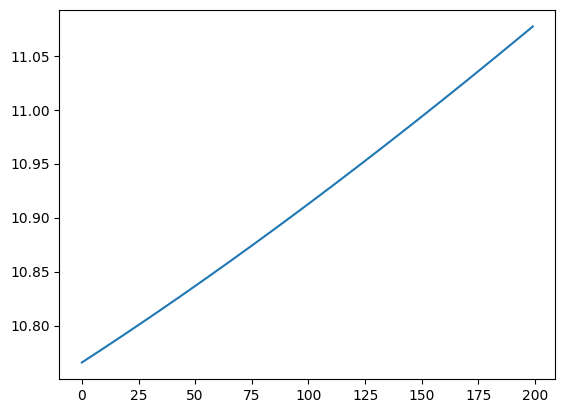

In [97]:
plt.plot(cost)

As shown in the graph the optimal lambda is 0. Therefore we fit our model with lambda = 0 and plot the result below


[[0.14911111]
 [0.79814392]]


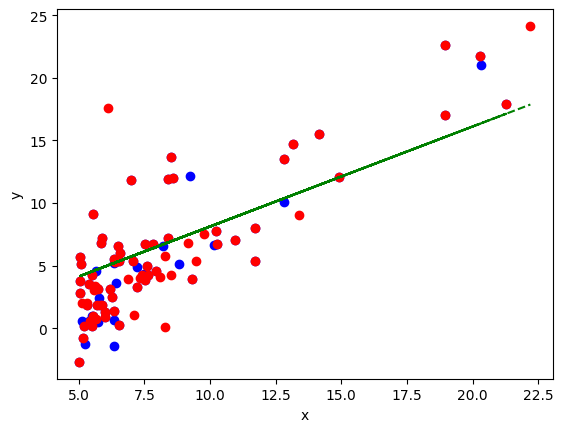

In [98]:
gradient = GradDescReg(0)

gradient.fit(x_train,y_train)
print(gradient._theta)
    
prediction = gradient.predict(x_test)

plotSingleRegression(x_train, y_train, x_test, y_test, prediction)


(77, 1)
(77,)
(78, 1)
(78,)


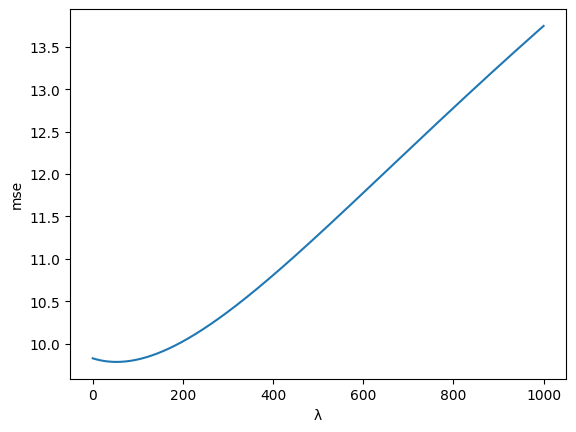

In [99]:
#3c
def mse(y, yp):
    
    diff = np.subtract(y, yp)
    return np.mean(np.square(diff))    #or: np.divide(np.dot(diff, diff), len(y))

#or: sklearn mse function
#from sklearn.metrics import mean_squared_error
    
def searchLambda(lbs, xf, yf, xt):
    
    print(xf.shape)
    print(yf.shape)
    print(xt.shape)
    print(y_test.shape)
    e = [ ]
    for l in lbs:
        lrr = NormalEQReg(l)
        lrr.fit(xf, yf)   
        ytp = lrr.predict(xt)
        e.append(mse(y_test, ytp))

    plt.plot(lbs, e)
    plt.xlabel('λ')
    plt.ylabel('mse')
    plt.show()
    return e

lbs0 = np.linspace(0,1000,1001)
y_train = y_train.reshape(len(x_train))
y_test = y_test.reshape(len(y_test))
e0   = searchLambda(lbs0, x_train, y_train, x_test)
    

(77, 1)
(77,)
(78, 1)
(78,)


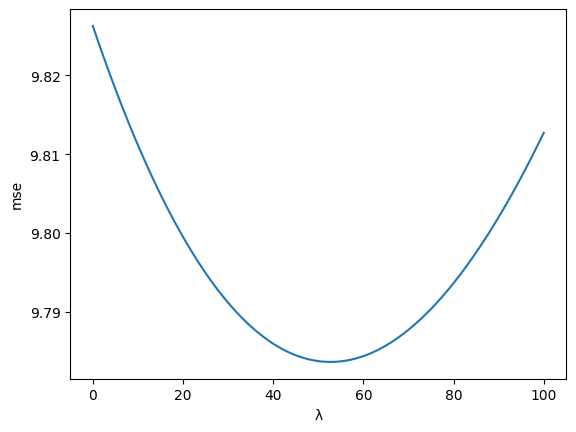

    λ          mse
0.00    9.82628
1.00    9.82461
2.00    9.82297
3.00    9.82137
4.00    9.81980
5.00    9.81827
6.00    9.81678
7.00    9.81532
8.00    9.81389
9.00    9.81251
10.00    9.81115
11.00    9.80983
12.00    9.80855
13.00    9.80730
14.00    9.80608
15.00    9.80490
16.00    9.80375
17.00    9.80263
18.00    9.80155
19.00    9.80051
20.00    9.79949
21.00    9.79851
22.00    9.79756
23.00    9.79665
24.00    9.79576
25.00    9.79491
26.00    9.79409
27.00    9.79331
28.00    9.79255
29.00    9.79183
30.00    9.79114
31.00    9.79048
32.00    9.78985
33.00    9.78925
34.00    9.78869
35.00    9.78815
36.00    9.78765
37.00    9.78717
38.00    9.78673
39.00    9.78631
40.00    9.78593
41.00    9.78558
42.00    9.78525
43.00    9.78496
44.00    9.78469
45.00    9.78446
46.00    9.78425
47.00    9.78408
48.00    9.78393
49.00    9.78381
50.00    9.78372
51.00    9.78365
52.00    9.78362
53.00    9.78361
54.00    9.78364
55.00    9.78369
56.00    9.78376
57.00    9.78387
58.00

In [100]:
lbs1 = np.linspace(0,100,101)
e1   = searchLambda(lbs1, x_train, y_train, x_test)

print('    λ          mse')    
for l, e in zip (lbs1, e1):
    print('{:.2f}    {:.5f}'.format(l, e))

As shown in above the optimal lambda is 14. So we fit the NormalEQReg with lambda = 14 and plot the results below

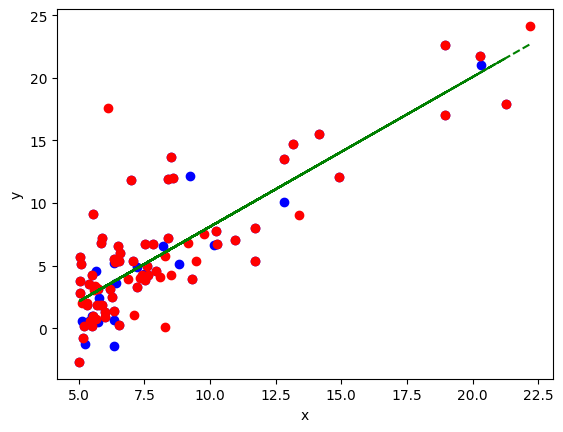

In [101]:
lrr = NormalEQReg(14.00 )
lrr.fit(x_train, y_train)   
ytp = lrr.predict(x_test)
plotSingleRegression(x_train, y_train, x_test, y_test, ytp)

In [102]:
#5a this code is from chatGPT I load them again later because i need them in numpy as well to fit my logRegLog class. 

import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV
data = pd.read_csv('lab04data.csv', header=None, names=["x1", "x2", "y"])

# Separate the classes
class_0 = data[data['y'] == 0]
class_1 = data[data['y'] == 1]

# Plot the two classes
plt.figure(figsize=(8, 6))
plt.scatter(class_0['x1'], class_0['x2'], label='Class 0', color='blue', marker='o')
plt.scatter(class_1['x1'], class_1['x2'], label='Class 1', color='red', marker='x')

# Add labels and title
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter plot of Class 0 and Class 1')
plt.legend()
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'pandas'

In [56]:
# here I tried to solve  5b
class RegLogReg(Classifier):
    
        
    def __init__(self,l:int, maxIter:int=30000, convDiff:float=10**-8, alpha:int=0.001 ):
        if l < 0:
            raise Exception('lambda must be >= 0')

        self._lambda = l
        self.alpha = alpha
        self.maxIter = maxIter
        self.convDiff = convDiff
        
    def mapFeature(self, X1, X2):
        '''
        Feature mapping function to polynomial features
        Maps the two input features to quadratic features used in regularization.

        Returns a new feature array with more features, comprising of 
        X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

        Inputs X1, X2 must have the same size
        '''

        degree = 6
        m = X1.shape[0]
        out = np.ones((m,1))
    
        for i in range (1,degree+1):
            for j in range(0,i+1):
                v = (X1**(i-j))*(X2**j)
                out = np.c_[out, v]
        return out

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    
    def predict(self,X_1,X_2):
        X = log.mapFeature(X_1,X_2)
        result = X.dot(log._theta)
        result = self.sigmoid(result)
        for index, value in enumerate(result):
            if value >= 0.5:
                result[index] =1
            if value < 0.5:
                result[index] =0
        return result
    
        
        
    def fit(self, X_1 : NDArray,X_2 : NDArray, y : NDArray):

        X = self.mapFeature(X_1,X_2)
       
        y = y.reshape(len(y),1)
        self._theta = np.ones((len(X[0]),1))
        m = len(X)
        print(X.shape)
        print(self._theta.shape)
        
       
       
        print("y: " + str(y.shape))
    
        
        for i in range(self.maxIter):
            z = np.dot(X,self._theta)
            error = self.sigmoid(z) - y
            
            gradient = (1/m) * np.dot(X.T, error)
            new_theta = self._theta - self.alpha * gradient
            self._theta = new_theta
        print(self._theta.shape)
        

(118, 28)
(28, 1)
y: (118, 1)
(28, 1)


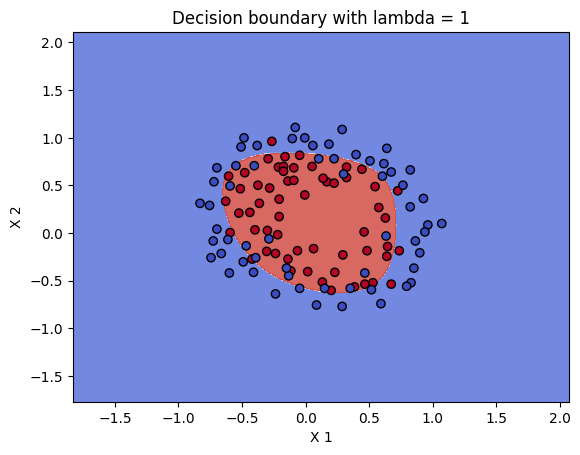

In [60]:
# Load the data
import pandas as pd
data = pd.read_csv('lab04data.csv', header=None, names=['Test 1', 'Test 2', 'Accepted'])

# The mapFeature function from map.py
def mapFeature(X1, X2):
    '''
    Feature mapping function to polynomial features
    Maps the two input features to quadratic features used in regularization.

    Returns a new feature array with more features, comprising of 
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

    Inputs X1, X2 must have the same size
    '''

    degree = 6
    m = X1.shape[0]
    out = np.ones((m,1))
    
    for i in range (1,degree+1):
        for j in range(0,i+1):
            v = (X1**(i-j))*(X2**j)
            out = np.c_[out, v]
    return out

# Create feature-mapped X values
X1 = data['Test 1'].values
X2 = data['Test 2'].values
y = data['Accepted'].values
 
X_mapped = mapFeature(X1, X2)
# Apply regularized logistic regression
lambda_value = 1 # controls the strength of the regularization (high value)
log = RegLogReg(1,150000)
log.fit(X1,X2, y)

# Define a function to plot the decision boundary
def plot_decision_boundary(clf, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

    # Predict the function value for the whole grid
    Z = log.predict(xx.ravel(), yy.ravel())
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X1, X2, c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('X 1')
    plt.ylabel('X 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title('Decision boundary with lambda = ' + str(lambda_value))

# Plot decision boundary
plot_decision_boundary(log, X_mapped, y)
plt.show()